<h1>Resumen de Implementación</h1>
<h2>Objetivo</h2>
    <p>El código entrena un modelo de deep learning para detectar puntos característicos en rostros.</p>

<h2>Descripción</h2>
    <ul>
        <li>Implementa un modelo de regresión basado en ResNet-18 para detectar puntos clave en rostros.</li>
        <li>El modelo estima 136 valores (68 puntos, cada uno con coordenadas x e y).</li>
    </ul>

<h2>Implementación Base</h2>
    <ul>
        <li>El código sigue la implementación de ResNet-18.</li>
        <li>Los datos de entrenamiento y validación se cargan desde archivos CSV.</li>
        <li>Se utiliza MSE como función de pérdida.</li>
    </ul>

<h2>Datos de Entrenamiento y Validación</h2>
    <p>Se asume que los datos de entrenamiento y validación están en archivos CSV proporcionados.</p>

   <h2>Función de Pérdida</h2>
   <p>Se utiliza MSE (Mean Square Error).</p>

<h2>Métricas</h2>
    <ul>
        <li>El código evalúa el modelo usando RMSE (Root Mean Square Error).</li>
        <li>También muestra visualmente las predicciones comparando los puntos reales y predichos.</li>
    </ul>
</body>
</html>


In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from resnet import ResNetBackbone
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Configurar el dispositivo para usar GPU si está disponible
device = tf.config.experimental.list_physical_devices('GPU')
if device:
    try:
        tf.config.experimental.set_memory_growth(device[0], True)
    except RuntimeError as e:
        print(e)

In [3]:
def visualize_predictions(model, images, keypoints, num_images=5):
    predictions = model.predict(images[:num_images])
    for i in range(num_images):
        image = images[i]
        true_keypoints = keypoints[i].reshape(-1, 2)
        predicted_keypoints = predictions[i].reshape(-1, 2)

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Mostrar la imagen
        axes[0].imshow(image)
        axes[0].axis('on')
        axes[0].set_title('Imagen')

        # Mostrar los puntos clave reales sin la imagen de fondo
        axes[1].scatter(true_keypoints[:, 0] * image.shape[1], true_keypoints[:, 1] * image.shape[0], c='r', marker='o')
        axes[1].set_title('Puntos Reales')
        axes[1].axis('equal')
        axes[1].invert_yaxis()
        axes[1].axis('on')

        # Mostrar los puntos clave predichos sin la imagen de fondo
        axes[2].scatter(predicted_keypoints[:, 0] * image.shape[1], predicted_keypoints[:, 1] * image.shape[0], c='b', marker='o')
        axes[2].set_title('Puntos Predichos')
        axes[2].axis('equal')
        axes[2].invert_yaxis()
        axes[2].axis('on')

        plt.show()

# Función para graficar imagen y puntos clave
def plot_image_with_keypoints(image, real_keypoints, pred_keypoints, ax_img, ax_kp):
    ax_img.imshow(image, cmap='gray', vmin=0, vmax=1)
    ax_img.axis('off')
    
    ax_kp.scatter(real_keypoints[0::2], real_keypoints[1::2], c='green', label='Real')
    ax_kp.scatter(pred_keypoints[0::2], pred_keypoints[1::2], c='red', label='Predicted')
    ax_kp.legend()
    ax_kp.axis('equal')
    
def visualize_image_and_keypoints(images, keypoints, index):
    """
    Muestra una imagen y sus puntos clave en dos gráficos separados, uno al lado del otro.
    
    Args:
    images (list): Lista de imágenes.
    keypoints (list): Lista de puntos clave correspondientes a las imágenes.
    index (int): Índice de la imagen y los puntos clave a visualizar.
    """
    # Seleccionar una imagen y sus puntos clave correspondientes
    example_image = images[index]
    example_keypoints = keypoints[index].reshape(-1, 2)

    # Crear una figura con dos subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Mostrar la imagen en el primer subplot
    axs[0].imshow(example_image)
    axs[0].set_title("Imagen de ejemplo")
    axs[0].axis('on')

    # Mostrar los puntos clave en el segundo subplot
    axs[1].scatter(example_keypoints[:, 0], example_keypoints[:, 1], c='r', marker='o')
    axs[1].invert_yaxis()  # Invertir el eje Y para que coincida con la representación de la imagen
    axs[1].set_title("Puntos clave")
    axs[1].set_xlabel("Eje X")
    axs[1].set_ylabel("Eje Y")
    axs[1].axis('on')

    # Ajustar el diseño para que los gráficos no se solapen
    plt.tight_layout()
    plt.show()

# Función para mostrar una imagen y sus puntos clave ajustados
def visualiza_imagen_keypoints(images, keypoints, indice, title="Imagen con puntos clave ajustados"):
    image = images[indice]
    keypoint = keypoints[indice].reshape(-1, 2)
    
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.scatter(keypoint[:, 0] * 256, keypoint[:, 1] * 256, c='r', marker='o')
    plt.title(title)
    plt.axis('on')
    plt.gca().invert_yaxis()  # Invertir el eje Y para que coincida con la representación de la imagen

    # Ajustar los límites del eje para que coincidan con la imagen
    plt.xlim(0, 256)
    plt.ylim(256, 0)

    # Mostrar el gráfico
    plt.show()
    
# Evaluación del modelo usando RMSE
def evaluate_model(model, images, keypoints):
    predictions = model.predict(images)
    mse = tf.keras.losses.MeanSquaredError()(keypoints, predictions)
    rmse = tf.sqrt(mse)
    print(f'RMSE en el conjunto de validación: {rmse:.4f}')
    return rmse

In [4]:
train_images=np.load('preprocessed_train_images.npy')
train_keypoints =np.load('preprocessed_train_keypoints.npy')
valid_images=np.load('preprocessed_valid_images.npy')
valid_keypoints =np.load('preprocessed_valid_keypoints.npy')

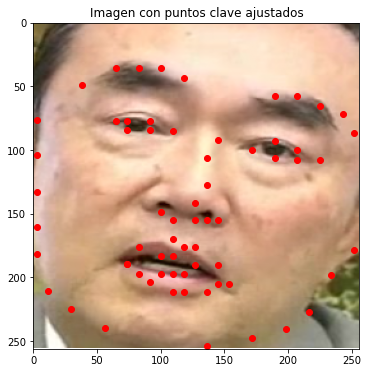

In [5]:
# Llamar a la función para visualizar la imagen y los puntos clave en el índice especificado
indice = 80
#visualize_image_and_keypoints(train_images, train_keypoints, indice)
visualiza_imagen_keypoints(train_images, train_keypoints, indice, title="Imagen con puntos clave ajustados")

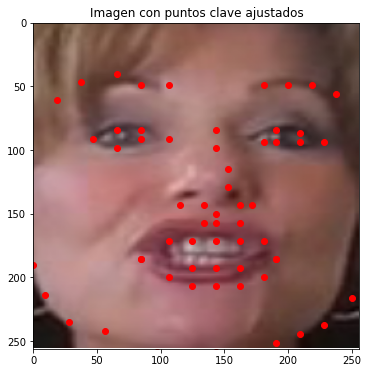

In [6]:
# Llamar a la función para visualizar la imagen y los puntos clave en el índice especificado
indice = 10
visualiza_imagen_keypoints(valid_images, valid_keypoints, indice)

![Arquitectura Tarea 1](https://www.notion.so/image/https%3A%2F%2Fprod-files-secure.s3.us-west-2.amazonaws.com%2Fbfe7784e-247c-4b96-9da6-87490828c7b1%2F8ca59957-19b7-4d11-9dfe-00bbf33416e6%2Fresnet_regressor.jpg?table=block&id=bd8cff83-138b-4d61-92f7-1bdb36cb5818&spaceId=bfe7784e-247c-4b96-9da6-87490828c7b1&width=2000&userId=744eb711-93f5-4675-b44c-a3df81dcccb3&cache=v2)

In [7]:
class KeypointModel(tf.keras.Model):
    def __init__(self):
        super(KeypointModel, self).__init__()
        self.resnet_backbone = ResNetBackbone(block_sizes=[2, 2, 2, 2], filters=[64, 128, 256, 512])
        
        self.fc = tf.keras.Sequential([
            tf.keras.layers.GlobalAveragePooling2D(), #Capa GAP
            tf.keras.layers.Dense(4096, activation='relu', kernel_initializer='he_normal'),  # Capa FC con 4096 neuronas
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(1024, activation='relu', kernel_initializer='he_normal'),  # Capa FC con 1024 neuronas
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(136, kernel_initializer='he_normal')  # 68 puntos clave * 2 (x, y)
        ])

    def call(self, inputs, training=False):
        x = self.resnet_backbone(inputs, training=training)
        x = self.fc(x)
        return x

## Model Build
Para el entrenamiento se sugiere utilizar MSE (Mean Square Error) como [función de pérdida](https://keras.io/api/losses/regression_losses/).

$ MSE = \frac{1}{n} \sum (y - \hat{y})^2$ \\

Para la evaluación cuantitativa deben reportar el [RMSE](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.root_mean_squared_error.html) (Root Mean Square Error)

$ RMSE = \sqrt{\frac{1}{n} \sum (y - \hat{y})^2}$

In [8]:
# Punto 2.3: Inicializar el modelo, la función de pérdida y el optimizador
model = KeypointModel()
# defining optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt,loss='mse',metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [9]:
# Implementar Early Stopping
early_stopping = EarlyStopping(monitor='val_root_mean_squared_error', patience=8, restore_best_weights=True)

In [10]:
# Entrenamiento del modelo
history = model.fit(train_images, train_keypoints, batch_size=64, epochs=40, validation_data=(valid_images, valid_keypoints),callbacks=[early_stopping])

Epoch 1/40
54/54 [==============================] - 698s 13s/step - loss: 0.1482 - root_mean_squared_error: 0.3849 - val_loss: 9.6712 - val_root_mean_squared_error: 3.1098
Epoch 2/40
54/54 [==============================] - 688s 13s/step - loss: 0.0362 - root_mean_squared_error: 0.1904 - val_loss: 45.7932 - val_root_mean_squared_error: 6.7671
Epoch 3/40
54/54 [==============================] - 645s 12s/step - loss: 0.0275 - root_mean_squared_error: 0.1657 - val_loss: 0.1984 - val_root_mean_squared_error: 0.4454
Epoch 4/40
54/54 [==============================] - 636s 12s/step - loss: 0.0245 - root_mean_squared_error: 0.1566 - val_loss: 0.1219 - val_root_mean_squared_error: 0.3491
Epoch 5/40
54/54 [==============================] - 635s 12s/step - loss: 0.0193 - root_mean_squared_error: 0.1389 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0959
Epoch 6/40
54/54 [==============================] - 646s 12s/step - loss: 0.0179 - root_mean_squared_error: 0.1338 - val_loss: 0.0109 - val

In [11]:
# Convertir el historial de entrenamiento a un DataFrame de Pandas
history_df = pd.DataFrame(history.history)

# Guardar el DataFrame como un archivo CSV
history_df.to_csv('training_history_epoch40-Arq2-RetinaFace_early_preprocess_2.csv', index=False)

In [12]:
# Guardar el modelo en el formato SavedModel
model.save('model-resnet-epoch40-Arq2-RetinaFace_early_preprocess_2', save_format='tf')

INFO:tensorflow:Assets written to: model-resnet-epoch40-Arq2-RetinaFace_early_preprocess_2\assets


INFO:tensorflow:Assets written to: model-resnet-epoch40-Arq2-RetinaFace_early_preprocess_2\assets


1/1 [==============================] - 1s 1s/step


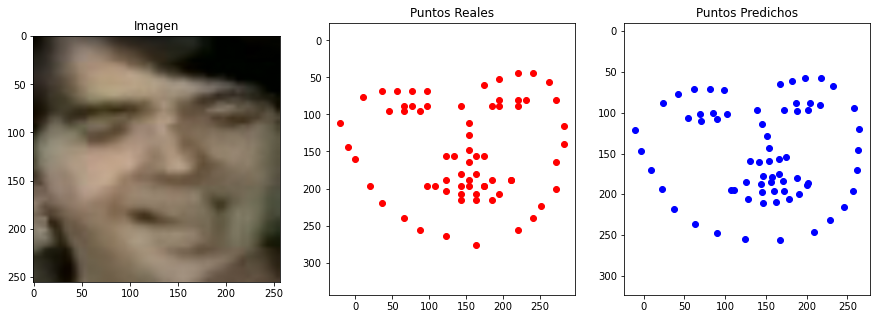

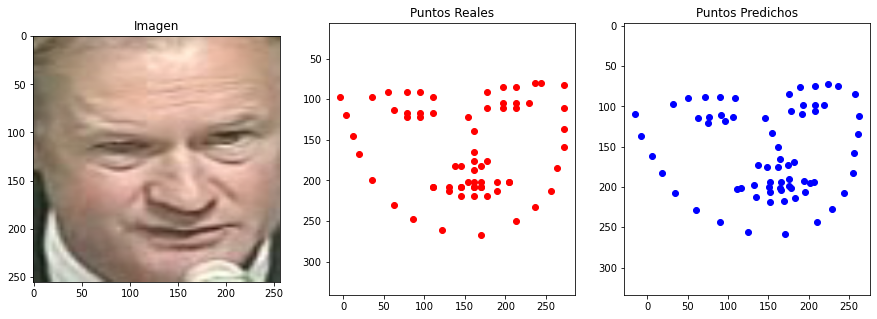

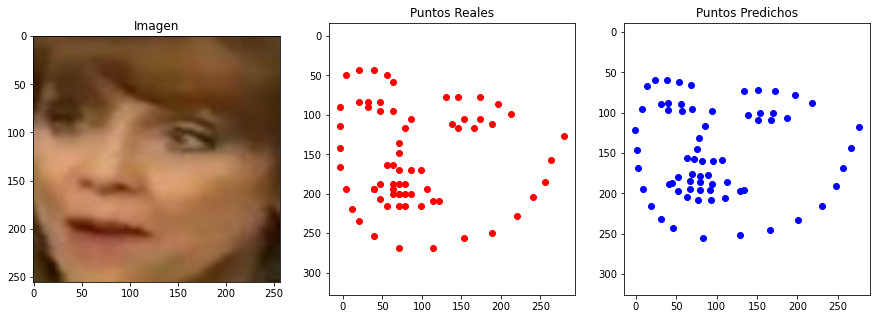

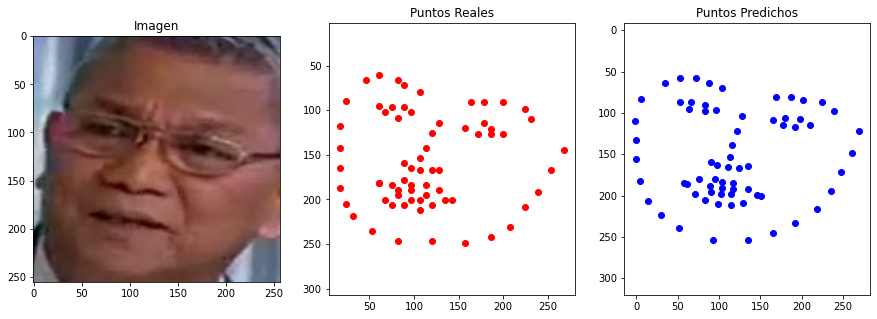

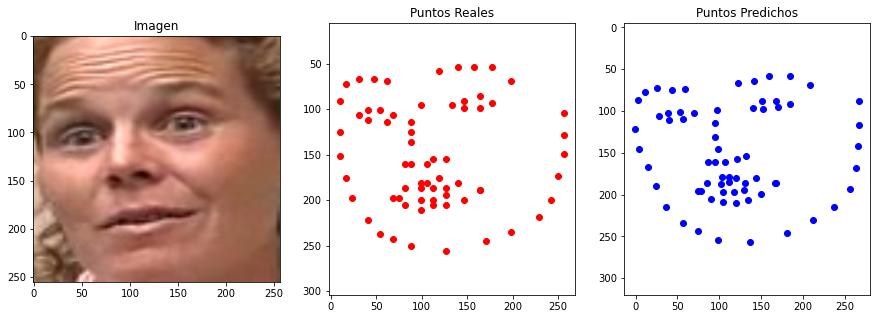

In [13]:
visualize_predictions(model, train_images, train_keypoints, num_images=5)

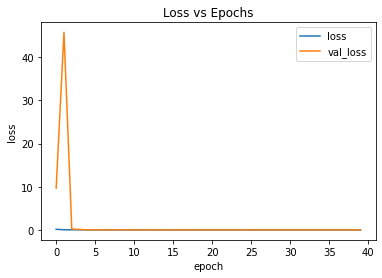

In [14]:
# Graficar la función de pérdida de entrenamiento y validación
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss vs Epochs')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc="upper right")
plt.show()

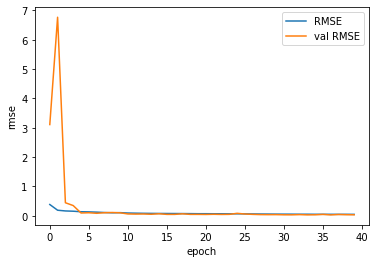

In [15]:
plt.plot(history.history['root_mean_squared_error'], label='RMSE')
plt.plot(history.history['val_root_mean_squared_error'], label='val RMSE')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(loc="upper right")
plt.show()

In [16]:
rmse_valid = evaluate_model(model, valid_images, valid_keypoints)

25/25 [==============================] - 30s 1s/step
RMSE en el conjunto de validación: 0.0343


In [17]:
rmse_train = evaluate_model(model, train_images, train_keypoints)

108/108 [==============================] - 132s 1s/step
RMSE en el conjunto de validación: 0.0347
